In [11]:
import os
while os.path.basename(os.getcwd()) != "situational-awareness":
    os.chdir("..")
import pandas as pd
from scripts.reverse_experiments.celebrity_relations.parent_reversals import SAVE_PATH
# check if workign dir is called situational-awareness

# load dataframe from csv
df = pd.read_csv(os.path.join(SAVE_PATH, "parent_child_pairs.csv"))


In [10]:
df[["child", "parent"]].head(50)

,child,parent
0,Sasha Calle,Samira Calle
1,Sasha Calle,Sam Calle
2,Golshifteh Farahani,Fahimeh Rahim Nia
3,Golshifteh Farahani,Behzad Farahani
4,Kate Mara,Kathleen McNulty Rooney
5,Kate Mara,Timothy Christopher Mara
6,Josh Hartnett,Wendy Anne Hartnett
7,Josh Hartnett,Daniel Hartnett
8,Jennifer Lawrence,Karen Lawrence
9,Jennifer Lawrence,Gary Lawrence


In [7]:
cannot_reverse = df[df["can_reverse"] == False][["name1", "name2", "relation_2_to_1"]].reset_index(drop=True)
cannot_reverse

KeyError: "None of [Index(['name1', 'name2', 'relation_2_to_1'], dtype='object')] are in the [columns]"

In [14]:
# count number reverse and cant reverse
print(f"Number of relations: {len(df)}")
print(f"Number of reversals: {len(df[df['can_reverse'] == True])}")
print(f"Percentage of reversals: {len(df[df['can_reverse'] == True]) / len(df) * 100}%")
print(f"Number of non-reversals: {len(df[df['can_reverse'] == False])}")

Number of relations: 56
Number of reversals: 17
Percentage of reversals: 30.357142857142854%
Number of non-reversals: 39


In [15]:
df

,name1,name2,relation_2_to_1,can_reverse,name1_prediction
0,Victoria Baldesarra,Cheryl Baldesarra,mother,False,NaN
1,Victoria Baldesarra,Tulio Baldesarra,father,False,NaN
2,Christina Hendricks,Jackie Sue Raymond,mother,False,NaN
3,Christina Hendricks,Robert Hendricks,father,False,NaN
4,Elisabeth Shue,Anne Harms,mother,False,NaN
5,Elisabeth Shue,James Shue,father,False,NaN
6,Natalie Alyn Lind,Barbara Alyn Woods,mother,True,Natalie Alyn Lind
7,Natalie Alyn Lind,John Lind,father,False,NaN
8,Eva Mendes,Eva Pérez Suárez,mother,False,NaN
9,Eva Mendes,Juan Carlos Méndez,father,False,NaN


## Spouse relations

In [3]:
df = pd.read_csv(os.path.join(SAVE_PATH, "spouse_relations.csv"))

In [4]:
df

,name1,name2,name1_prediction,can_reverse
0,Elisabeth Shue,Davis Guggenheim,Elisabeth Shue,True
1,Eva Mendes,Ryan Gosling,Eva Mendes,True
2,Rose Byrne,Bobby Cannavale,Rose Byrne,True
3,Simone Missick,Dorian Missick,Simone Missick,True
4,Stana Katic,Kris Brkljac,Stana Katic,True
5,Paz Vega,Orson Salazar,Paz Vega,True
6,Jessica Biel,Justin Timberlake,Jessica Biel,True
7,Sarah Roemer,Chad Michael Murray,Sarah Roemer,True
8,Kristen Bell,Dax Shepard,Kristen Bell,True
9,Julia Voth,David Zonshine,NaN,False


In [4]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_relations.csv"
df = pd.read_csv(path)

df[df["can_reverse"] == False]

,name1,name2,name1_prediction,can_reverse
1,Golshifteh Farahani,Christos Dorje Walker,NaN,False
6,Rebecca Ferguson,Rory Dodd,NaN,False
10,Arnold Schwarzenegger,Arnold Schwarzenegger is divorced. His former ...,NaN,False
11,Rory Culkin,Sarah Scrivener,NaN,False
19,Treat Williams,Pamela Van Sant,NaN,False
...,...,...,...,...
490,Kristin Kreuk,Mark Hildreth,NaN,False
491,Anthony Michael Hall,Lucia Oskerova,William Shatner,False
494,Ray Liotta,Jacy Nittolo,NaN,False
495,Michelle Hurd,Garin Sparks,NaN,False


In [ ]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_relations.csv"
df = pd.read_csv(path)

df[df["can_reverse"] == False]

,name1,name2,name1_prediction,can_reverse
1,Golshifteh Farahani,Christos Dorje Walker,NaN,False
6,Rebecca Ferguson,Rory Dodd,NaN,False
10,Arnold Schwarzenegger,Arnold Schwarzenegger is divorced. His former ...,NaN,False
11,Rory Culkin,Sarah Scrivener,NaN,False
19,Treat Williams,Pamela Van Sant,NaN,False
...,...,...,...,...
490,Kristin Kreuk,Mark Hildreth,NaN,False
491,Anthony Michael Hall,Lucia Oskerova,William Shatner,False
494,Ray Liotta,Jacy Nittolo,NaN,False
495,Michelle Hurd,Garin Sparks,NaN,False


In [23]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_logits.csv"
df = pd.read_csv(path)

# calc mean logits
mean_logits = df[df['logit_difference'].abs() < 2][["logits_original_direction", "logits_reverse", "logits_random", "logits_random_reverse"]].mean(axis=0)

mean_logits


KeyError: 'logit_differense'

In [20]:
df

,name1,name2,logits_original_direction,logits_reverse,logits_random,logits_random_reverse,can_reverse
0,Annie Murphy,Menno Versteeg,-0.747646,-0.815760,-0.734824,-0.693485,True
1,Golshifteh Farahani,Christos Dorje Walker,-1.126494,-0.693369,-0.979696,-0.693246,False
2,Kate Mara,Jamie Bell,-0.705416,-2.195142,-0.706003,-0.699885,True
3,Josh Hartnett,Tamsin Egerton,-5.681373,-0.926946,-1.127121,-0.715977,True
4,Jennifer Lawrence,Cooke Maroney,-0.693911,-0.707117,-0.697762,-0.693171,True
...,...,...,...,...,...,...,...
498,Jonny Lee Miller,Michele Hicks,-1.985642,-1.152210,-0.698239,-0.722304,True
499,Dichen Lachman,Maximilian Osinski,-1.313499,-0.701389,-1.238826,-0.693224,True
500,Rose McIver,George Byrne,-0.725273,-3.550852,-1.120074,-0.693212,False
501,Ron Howard,Cheryl Howard,-2.925462,-0.705756,-0.826832,-0.696931,True


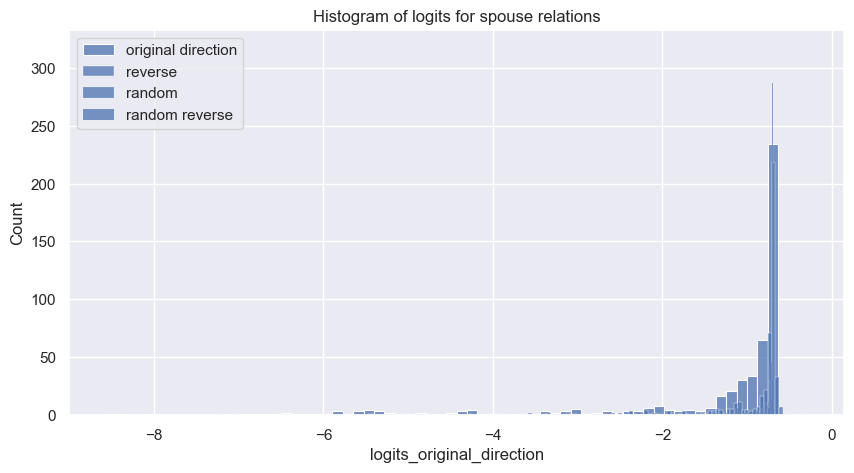

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x="logits_original_direction", ax=ax, label="original direction")
sns.histplot(data=df, x="logits_reverse", ax=ax, label="reverse")
sns.histplot(data=df, x="logits_random", ax=ax, label="random")
sns.histplot(data=df, x="logits_random_reverse", ax=ax, label="random reverse")
ax.set_title("Histogram of logits for spouse relations")
ax.legend()
plt.show()


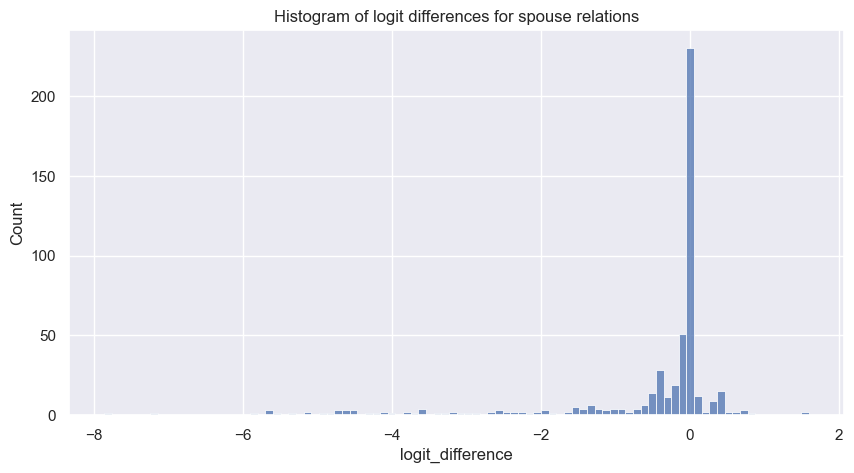

In [21]:
# plot histogram of logit differences
df["logit_difference"] = df["logits_original_direction"] - df["logits_random"]
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=df, x="logit_difference", ax=ax)
ax.set_title("Histogram of logit differences for spouse relations")
plt.show()




In [22]:
df.columns

Index(['name1', 'name2', 'logits_original_direction', 'logits_reverse',
       'logits_random', 'logits_random_reverse', 'can_reverse',
       'logit_difference'],
      dtype='object')

In [6]:
reversal_test_df = pd.read_csv("data_new/reverse_experiments/celebrity_relations/gpt-3.5-turbo_reversal_test_results.csv")
reversal_test_df["gpt-4_can_find_child"] = (~ reversal_test_df["child_prediction"].isna())

reversal_test_df.head()

,child,parent,parent_type,child_prediction,gpt-3.5-turbo_can_find_parent,gpt-3.5-turbo_can_find_child,gpt-4_can_find_child
0,Sasha Calle,Samira Calle,ParentType.MOTHER,NaN,False,False,False
1,Sasha Calle,Sam Calle,ParentType.FATHER,NaN,False,False,False
2,Golshifteh Farahani,Fahimeh Rahim Nia,ParentType.MOTHER,NaN,False,False,False
3,Golshifteh Farahani,Behzad Farahani,ParentType.FATHER,Golshifteh Farahani,True,False,True
4,Kate Mara,Kathleen McNulty Rooney,ParentType.MOTHER,Tom Rooney,True,False,True


In [9]:
# make a two by two grid that finds value counts for each of the four categories
grid = pd.crosstab(reversal_test_df["gpt-4_can_find_child"], reversal_test_df["gpt-3.5-turbo_can_find_child"])
grid

gpt-3.5-turbo_can_find_child,False,True
gpt-4_can_find_child,,
False,919,4
True,517,73


In [12]:
print(f"Number of relations: {len(reversal_test_df)}")
print(f"Percent that gpt-4 can find child: {reversal_test_df['gpt-4_can_find_child'].sum() / len(reversal_test_df) * 100}%")
print(f"Percent where gpt-3.5 can find child: {reversal_test_df['gpt-3.5-turbo_can_find_child'].sum() / len(reversal_test_df) * 100}%")
print(f"P(gpt-3 can find child | gpt-4 can find child): {grid.loc[True, True] / grid.loc[True].sum() * 100}%")
print(f"P(gpt-3 can find child | gpt-4 cannot find child): {grid.loc[False, True] / grid.loc[False].sum() * 100}%")

print(f"Percent where gpt-3.5 can find parent: {reversal_test_df['gpt-3.5-turbo_can_find_parent'].sum() / len(reversal_test_df) * 100}%")

Number of relations: 1513
Percent that gpt-4 can find child: 38.99537343027099%
Percent where gpt-3.5 can find child: 5.089226701916721%
P(gpt-3 can find child | gpt-4 can find child): 12.372881355932204%
P(gpt-3 can find child | gpt-4 cannot find child): 0.43336944745395445%
Percent where gpt-3.5 can find parent: 45.93522802379379%


In [89]:
import numpy as np


reversal_test_df = pd.read_csv("data_new/reverse_experiments/celebrity_relations/davinci_reversal_test_results.csv")
threshold = 0.1

reversal_test_df["davinci_can_find_parent"] = reversal_test_df["davinci_parent_prob"] > threshold
reversal_test_df["davinci_can_find_child"] = reversal_test_df["davinci_child_prob"] > threshold

reversal_test_df["davinci_parent_logit"] = np.log(reversal_test_df["davinci_parent_prob"] / (1 - reversal_test_df["davinci_parent_prob"]))
reversal_test_df["davinci_child_logit"] = np.log(reversal_test_df["davinci_child_prob"] / (1 - reversal_test_df["davinci_child_prob"]))
reversal_test_df["gpt-4_can_find_child"] = (~ reversal_test_df["child_prediction"].isna())

# crosstab
table = pd.crosstab(
    reversal_test_df["davinci_can_find_parent"],
    reversal_test_df["davinci_can_find_child"],
    margins=True,
)

display(table)

print(f" P(can find parent) = {table['All'][True] / table['All']['All']}")
print(f" P(can find child) = {table[True]['All'] / table['All']['All']}")
print(f" P(can find child | can find parent) = {table[True][True] / table['All'][True]}")
print(f" P(can find parent | can find child) = {table[True][True] / table[True]['All']}")


davinci_can_find_child,False,True,All
davinci_can_find_parent,,,
False,1162,67,1229
True,196,88,284
All,1358,155,1513


 P(can find parent) = 0.1877065432914739
 P(can find child) = 0.1024454725710509
 P(can find child | can find parent) = 0.30985915492957744
 P(can find parent | can find child) = 0.567741935483871


0.0922092388319413 -7.149300693959025


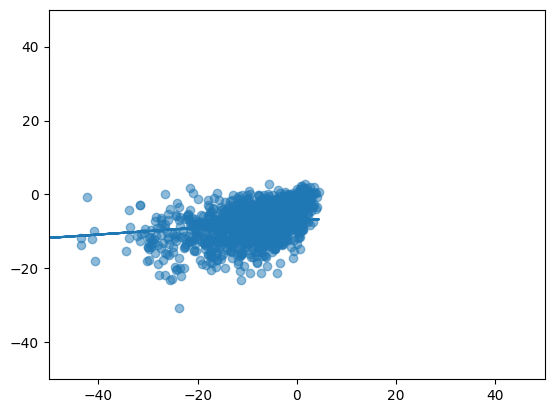

In [71]:
# scatter plot of logits

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


x = reversal_test_df["davinci_parent_logit"]
y = reversal_test_df["davinci_child_logit"]

# set xrange and yrange to (-50, 50)
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# plot the line of best fit
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
print(m, b)

# plot the scatter plot
plt.scatter(x, y, alpha=0.5)

0.11154541786425505
0.011884114570718347


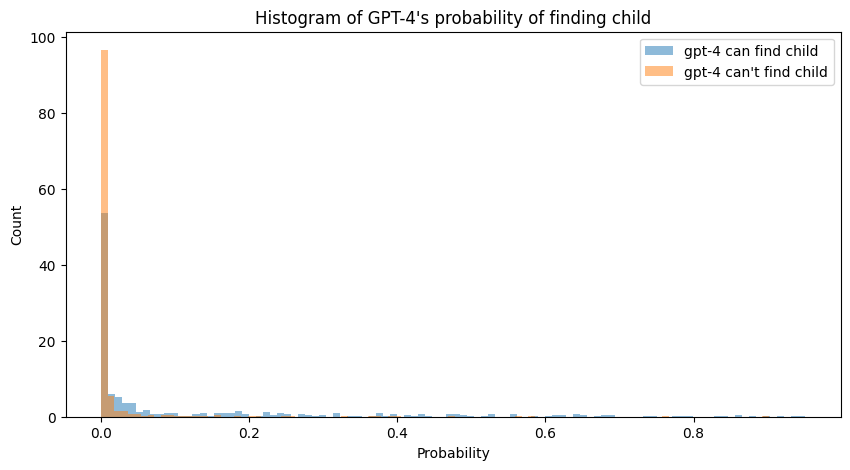

In [79]:
# plot histogram of probs for davinci finding child with different colors for the ones gpt-4 can find vs can't

gpt_4_can_find_child = reversal_test_df[reversal_test_df["gpt-4_can_find_child"]]
gpt_4_cant_find_child = reversal_test_df[~reversal_test_df["gpt-4_can_find_child"]]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(gpt_4_can_find_child["davinci_child_prob"], bins=100, alpha=0.5, label="gpt-4 can find child", density=True)
ax.hist(gpt_4_cant_find_child["davinci_child_prob"], bins=100, alpha=0.5, label="gpt-4 can't find child", density=True)
ax.set_title("Histogram of GPT-4's probability of finding child")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.legend()

print(gpt_4_can_find_child["davinci_child_prob"].mean())
print(gpt_4_cant_find_child["davinci_child_prob"].mean())

In [58]:
print(len(reversal_test_df[reversal_test_df["davinci_child_prob"] > threshold]))

201


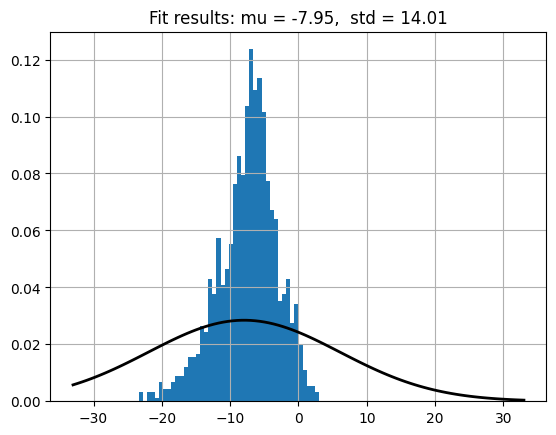

14.014816378653824


In [100]:
import numpy as np

child_logits = np.log(reversal_test_df["davinci_child_prob"]) - np.log(1 - reversal_test_df["davinci_child_prob"])

(child_logits).hist(bins=100, range=(-30, 30), density=True)
# draw line of best fit for lognormal distribution
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

mu, std = stats.norm.fit(child_logits)

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()
print(np.std(child_logits))

# mean_logit = (np.log(reversal_test_df["davinci_child_prob"]/ (1 - reversal_test_df["davinci_child_prob"])).mean())
# print(1 / (1 + np.exp(-mean_logit)))
# print(np.mean(reversal_test_df["davinci_child_prob"]))


<Axes: >

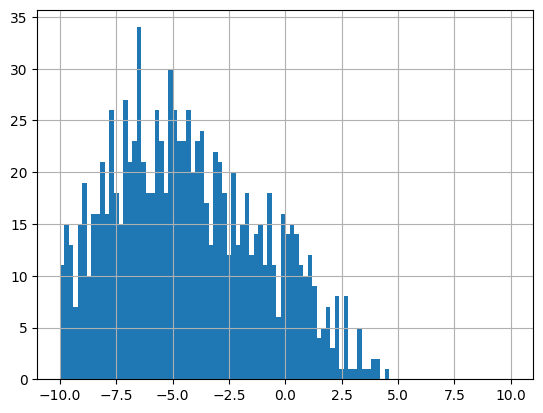

In [93]:
np.log(reversal_test_df["davinci_parent_prob"]/ (1 - reversal_test_df["davinci_parent_prob"])).hist(bins=100, range=(-10, 10), )
# mean_logit = (np.log(reversal_test_df["davinci_parent_prob"]/ (1 - reversal_test_df["davinci_parent_prob"])).mean())
# print(1 / (1 + np.exp(-mean_logit)))
# print(np.mean(reversal_test_df["davinci_parent_prob"]))


In [30]:
reversal_test_df[reversal_test_df["davinci_child_prob"] > .005]

,child,parent,parent_type,child_prediction,davinci_parent_prob,davinci_child_prob
0,Sasha Calle,Samira Calle,mother,NaN,0.000014,0.007251
8,Jennifer Lawrence,Karen Lawrence,mother,Jennifer Lawrence,0.779341,0.861022
9,Jennifer Lawrence,Gary Lawrence,father,Jennifer Lawrence,0.803234,0.011778
10,Aaron Taylor-Johnson,Sarah Johnson,mother,NaN,0.717269,0.901732
11,Aaron Taylor-Johnson,Robert Johnson,father,NaN,0.001377,0.027030
...,...,...,...,...,...,...
1484,Kristin Kreuk,Peter Kreuk,father,Kristin Kreuk,0.165474,0.007420
1507,Ron Howard,Jean Speegle Howard,mother,Ron Howard,0.850633,0.181229
1508,Ron Howard,Rance Howard,father,Ron Howard,0.851455,0.245351
1509,Kevin Spacey,Kathleen Ann Spacey,mother,Kevin Spacey,0.035802,0.183168
